In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import astropy.units as u

from matplotlib.colors import Normalize

from scipy.interpolate import interp2d
import matplotlib.patheffects as path_effects

In [2]:
m1 = 0.9
m2 = 0.1
m3 = 0.08
sep = 0.22
c1 = ((m1 * sep/2) + (m2 * -sep/2))/(m1 + m2)
c2 = ((m1 * sep/2) + (m3 * -sep/2))/(m1 + m3)

In [3]:
# tess_cdpp = lambda x: np.polyval(np.polyfit([9, 12.5, 15], [6-2, 6-3, 6-4], 1), x)

# plt.plot(delta_mag, 10**-tess_cdpp(delta_mag + source_mag), c='k', ls='--', zorder=21)
# plt.fill_between(delta_mag, 10**-tess_cdpp(delta_mag + source_mag), color='grey', alpha=0.9, zorder=20)


$$m_1 = 1 - m_2$$
$$m_3 = m_2 - A*m_2$$

$$m_1 + m_3 = 1 - \tau_d$$
$$m_3 = 1 - \tau_d  - m_1$$
$$1 - \tau_d  - m_1 = m_2 - A*m_2$$
$$1 - \tau_d  - m_1 = m_2(1 - A)$$
$$(1 - \tau_d  - m_1)/m_2 = 1 - A$$
$$A = 1 - (1 - \tau_d  - m_1)/m_2$$
$$A = 1 - (1 - \tau_d  - (1 - m_2)/m_2$$
$$A = 1 - (\tau_d  + m_2)/m_2$$


Total flux in the system sums to 1.

$$m_1 + m_2 = 1$$

There is an eclipse with depth $\delta$. The second source flux during eclipse we will denote as $m_2'$

$$\delta = 1 - (m1 + m_2')$$
$$m_2' = m_2 - A*m_2$$

Rearranging we find

$$A = 1 - (\delta + m_2)/m_2$$

Now, for any values of $m_2$, we can calculate A, the eclipse depth of the polutant

Center of Mass Equation is
$$x_c = \frac{m_1x_1 + m_2x_2}{m_1 + m_2}$$

Which if we assume some separation $\alpha$ between sources we can write

$$x_c = \frac{m_1\alpha - m_2\alpha}{2(m_1 + m_2)}$$


The change in center of mass during eclipse will be

$$\Delta x_c = \frac{m_1\alpha - m_2\alpha}{2(m_1 + m_2)} -  \frac{m_1\alpha - m_2'\alpha}{2(m_1 + m_2')}$$

We know that $\Delta x_c$ must be **no greater than** than some limit set by our centroiding test, and $m_2'$ must give a consistent transit depth **no shallower than** true transit depth.

In [7]:
source_counts = 1e6
noise_floor = 1
true_transit_depth = 0.001
lim = 0.001

m2 = np.logspace(-2.5, 1, 500)
delta_mag = -2.5 * np.log10(m2)

cmap = plt.get_cmap("Greys")
cmap.set_bad(alpha=0)

A = 1 - (-true_transit_depth + m2)/m2
m1 = 1 - m2
m3 = (m2 - A * m2)

#Pixels 
sep = np.logspace(-1.5, np.log10(2), 100)[1:]
com1 = ((m1 * sep[:, None]/2) + (m2 * -sep[:, None]/2))/(m1 + m2)
com2 = ((m1 * sep[:, None]/2) + (m3 * -sep[:, None]/2))/(m1 + m3)
dcom = com2 - com1
contaminant_eclipse_depth = 1 - m3

Blends not ruled out


Text(0.5, 1.0, 'Centroid Limit = 0.001, Measured Transit Depth = 0.001')

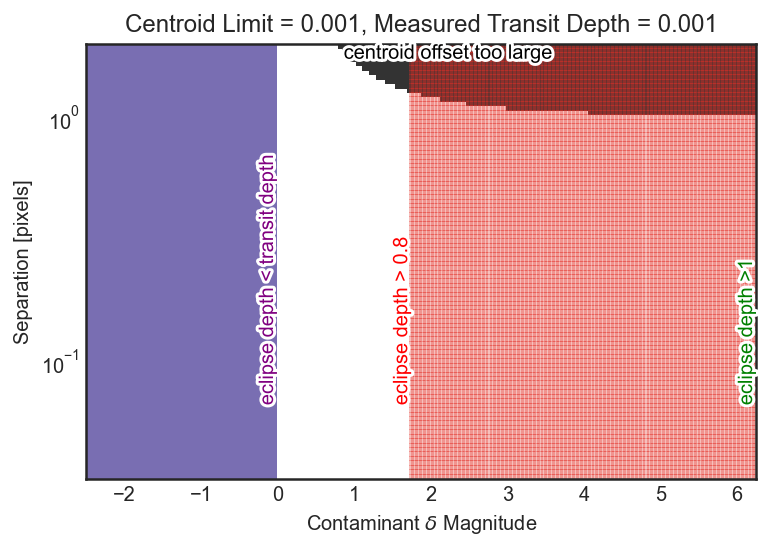

In [8]:
# No centroid shift detected
if (dcom > lim).any():
    plt.pcolormesh(delta_mag, sep, np.nan**(dcom < lim), vmin=0, vmax=1.2)
    text = plt.text(delta_mag[np.where((dcom > lim).any(axis=0))[0][-1]] + 0.1, sep.max(), 'centroid offset too large', va='top', c='k')

    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),
                       path_effects.Normal()])


# grad = np.abs((np.gradient((dcom < lim).astype(float))[0])) == 0.5
# l = np.asarray([np.where(g)[0][-1] + 1 if g.sum() != 0 else -1 for g in grad.T])
# plt.fill_between(delta_mag, sep.max(), sep[l], alpha=1, color='k')


# Contaminant Eclipse is smaller than transit signal
if (contaminant_eclipse_depth <= true_transit_depth).any():
    cmap = plt.get_cmap("Purples")
    cmap.set_bad(alpha=0)
    plt.pcolormesh(delta_mag, sep, np.nan**(contaminant_eclipse_depth * np.ones_like(dcom) > true_transit_depth), cmap=cmap, vmin=0, vmax=1.5)
    text = plt.text(delta_mag[np.where(contaminant_eclipse_depth <= true_transit_depth)[0].min()], sep.min() * 2, 'eclipse depth < transit depth', rotation=90, va='bottom', ha='right', c='Purple', zorder=20)

    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),
                       path_effects.Normal()])
    

# Transit is too deep to be physical
if (contaminant_eclipse_depth > 0.8).any():
    cmap = plt.get_cmap("Reds")
    cmap.set_bad(alpha=0)
    plt.pcolormesh(delta_mag, sep, np.nan**(contaminant_eclipse_depth * np.ones_like(dcom) < 0.8), cmap=cmap, vmin=0, vmax=1.5, alpha=0.3)
    text = plt.text(delta_mag[np.where(contaminant_eclipse_depth > 0.8)[0].max()], sep.min() * 2, 'eclipse depth > 0.8', rotation=90, va='bottom', ha='right', c='Red', zorder=20)

    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),
                       path_effects.Normal()])
    
# Second source is too faint to detect
if source_counts is not None:
    if ((m3 * source_counts) <= noise_floor).any():
        cmap = plt.get_cmap("Blues")
        cmap.set_bad(alpha=0)
        plt.pcolormesh(delta_mag, sep, np.nan**((m3 * np.ones_like(dcom) * source_counts) >= noise_floor), cmap=cmap, vmin=0, vmax=1.5, zorder=20)
        text = plt.text(delta_mag[np.where((m3 * source_counts) <= noise_floor)[0].min()], sep.min() * 2, 'second source is too faint to detect', rotation=90, va='bottom', ha='right', c='Blue', zorder=20)

        text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),
                           path_effects.Normal()])
    
# Can't create deep enough transit
if (m3 >= 0).any():
    cmap = plt.get_cmap("Greens")
    cmap.set_bad(alpha=0)
    plt.pcolormesh(delta_mag, sep, np.nan**(m3 * np.ones_like(dcom) >= 0), cmap=cmap, vmin=0, vmax=1.5, zorder=30)
    text = plt.text(delta_mag[np.where(m3 >= 0)[0].min()], sep.min() * 2, 'eclipse depth >1', rotation=90, va='bottom', ha='right', c='Green', zorder=30)

    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),
                       path_effects.Normal()])
    

total = ((dcom > lim) | (contaminant_eclipse_depth > 0.8) | (m3 <= 0))
if source_counts is not None:
    total |= ((m3 * source_counts) < noise_floor)

if not (dcom > lim).any():
    cut = np.max(sep)
else:
    grad = np.abs(np.gradient(total.astype(float))[0]) == 0.5
    l = np.asarray([np.where(g)[0].max() + 1 if g.sum() != 0 else 0 for g in grad.T])
    cut = np.max(sep[l])
    
if cut == np.max(sep):
    print('Blends not ruled out')
else:
    print(f'Blends ruled out down to {np.round(cut, 1)} Pixels')
#    plt.axhline(cut, ls='--', color='w', zorder=40)
#    text = plt.text(delta_mag[int(0.1*len(delta_mag))], cut, f'{np.round(cut, 1)} Pix', c='Grey', ha='center', va='bottom', zorder=40)

#    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),
#                       path_effects.Normal()])
    
plt.yscale('log')
plt.xlabel('Contaminant $\delta$ Magnitude')
plt.ylabel('Separation [pixels]')

plt.title(f'Centroid Limit = {lim}, Measured Transit Depth = {true_transit_depth}')


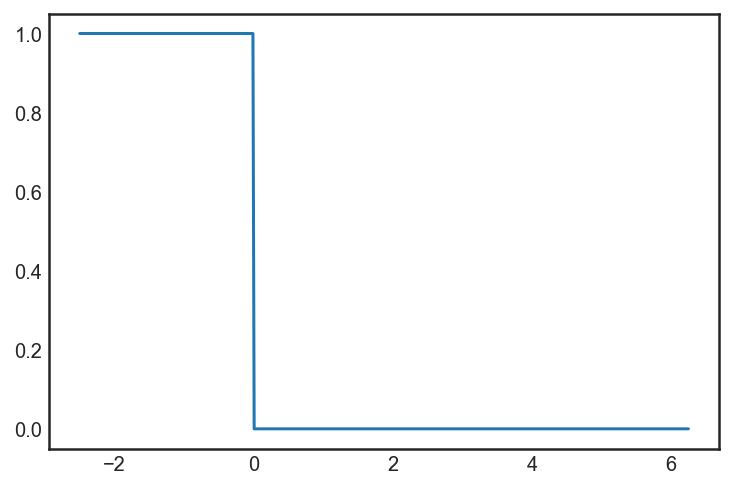

In [6]:
plt.plot(delta_mag, contaminant_eclipse_depth < true_transit_depth)

In [1860]:
sep = np.logspace(-1.5, np.log10(27), 10)[1:]*u.arcsec / (27*u.arcsecond/u.pixel)
m2_ar = np.logspace(-6, 0, 500)
rat_ar = np.logspace(-3, 0, 1000)[1:]

#m2_ar = np.linspace(0, 1, 20)[1:]
#rat_ar = np.linspace(0.1, 0.5, 10)[1:]

norm = Normalize(vmin=np.log10(sep.value.min()), vmax=np.log10(sep.value.max()))
cmap = plt.get_cmap('viridis')

In [1861]:
delta_mag = -2.5 * np.log10(m2_ar)

In [1862]:
m2 = m2_ar[:, None, None]
m1 = 1 - np.copy(m2)

# Flux in transit
m3 = np.copy(m2) - np.copy(m2)*rat_ar[None, :, None]

In [1863]:
com1 = ((m1 * sep/2) + (m2 * -sep/2))/(m1 + m2)
com2 = ((m1 * sep/2) + (m3 * -sep/2))/(m1 + m3)
dcom = com2 - com1

/Users/ch/miniconda3/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [1864]:
transit_depth = (1 - (m1 + m3))[:, :, 0]

In [1865]:
lim = 0.0001

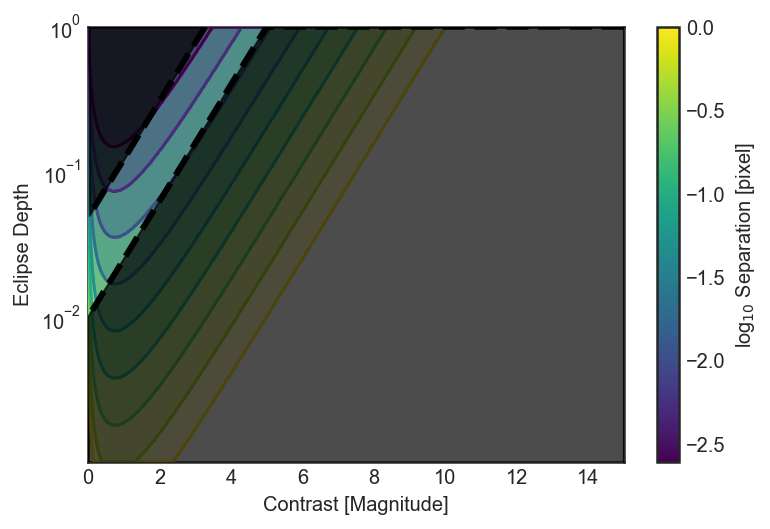

In [1866]:
for sdx in range(len(sep))[::-1]:
    l = np.argmin(np.abs(dcom.value[:, :, sdx] - lim), axis=1)
    #plt.pcolormesh(m2_ar, rat_ar, dcom.value[:, :, sdx].T < lim)
    plt.scatter(delta_mag, rat_ar[l], c=np.log10(np.ones(len(delta_mag)) * sep.value[sdx]), cmap='viridis', vmin=np.log10(sep.value.min()), vmax=np.log10(sep.value.max()), s=0.1)
    plt.plot(delta_mag, rat_ar[l], color=cmap(norm(np.log10(sep.value[sdx]))), zorder=10)

    plt.fill_between(delta_mag, 1, (rat_ar[l]), alpha=0.3, color=cmap(norm(np.log10(sep.value[sdx]))))

plt.xlabel('Contrast [Magnitude]')
plt.ylabel('Eclipse Depth')
cbar = plt.colorbar()
cbar.set_label('log$_{10}$ Separation [pixel]')



# cmap_bw = plt.get_cmap('Greys')
# cmap_bw.set_bad(alpha=0)

# transit_depth_mask = np.nan**(transit_depth.T > true_transit_depth)
# plt.pcolormesh(delta_mag, rat_ar, transit_depth_mask, cmap=cmap_bw, vmin=0, vmax=1, zorder=20, alpha=0.1)

l = np.argmin(np.abs(transit_depth - true_transit_depth), axis=1)
plt.fill_between(delta_mag, rat_ar[l], color='k', alpha=0.7, zorder=30)
plt.plot(delta_mag, rat_ar[l], color='k', ls='--', lw=3, zorder=31)

grad = (np.gradient((transit_depth > 5*true_transit_depth).astype(float))[0]) == 0.5
l = np.asarray([np.where(g)[0][0] if g.sum() != 0 else 0 for g in grad])
plt.fill_between(delta_mag[l != 0], rat_ar[l[l != 0]], 1, color='k', alpha=0.7, zorder=30)
plt.plot(delta_mag[l != 0], rat_ar[l[l != 0]], color='k', ls='--', lw=3, zorder=31)



#floor_mask = np.nan**((rat_ar * m2_ar[:, None] * source_counts).T > tess_noise_floor)
#plt.pcolormesh(delta_mag, rat_ar, floor_mask, cmap=cmap_bw, vmin=0, vmax=1.4, zorder=20, alpha=0.4)


plt.ylim(rat_ar.min(), 1)
plt.xlim(0, delta_mag.max())
plt.yscale('log')



In [1867]:
transit_depth

array([[1.00693864e-09, 1.01392539e-09, 1.02096065e-09, ...,
        9.86265846e-07, 9.93109181e-07, 1.00000000e-06],
       [1.03520670e-09, 1.04238962e-09, 1.04962239e-09, ...,
        1.01395351e-06, 1.02098896e-06, 1.02807322e-06],
       [1.06426823e-09, 1.07165277e-09, 1.07908860e-09, ...,
        1.04241845e-06, 1.04965141e-06, 1.05693455e-06],
       ...,
       [9.52697239e-04, 9.59307655e-04, 9.65963937e-04, ...,
        9.33138048e-01, 9.39612749e-01, 9.46132376e-01],
       [9.79442522e-04, 9.86238513e-04, 9.93081659e-04, ...,
        9.59334241e-01, 9.65990708e-01, 9.72693362e-01],
       [1.00693863e-03, 1.01392541e-03, 1.02096066e-03, ...,
        9.86265846e-01, 9.93109181e-01, 1.00000000e+00]])

In [1868]:
f = interp2d(m2_ar, rat_ar, transit_depth.T)

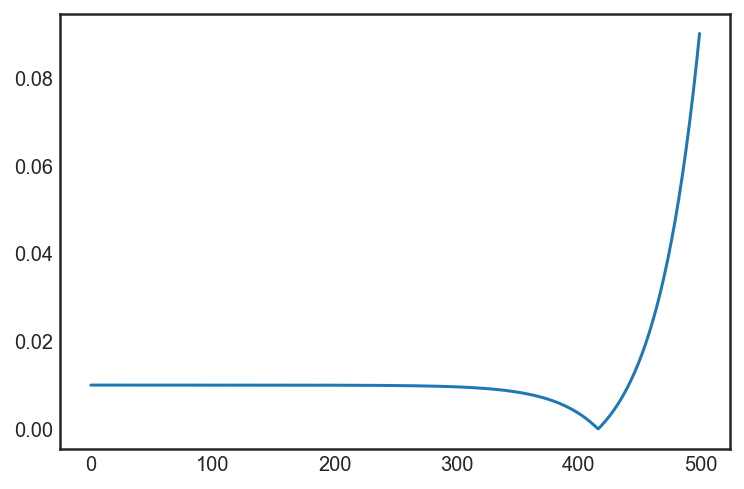

In [1869]:
plt.plot(np.abs(f(m2_ar, 0.1) - true_transit_depth))

NameError: name 'g' is not defined

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  n

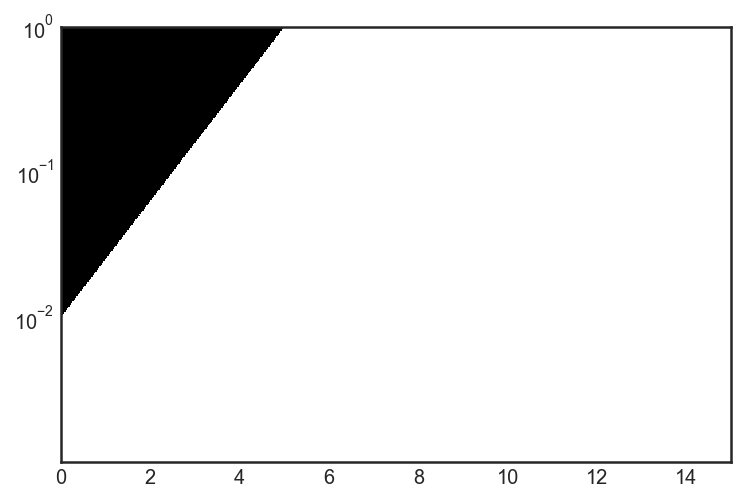

In [1182]:
plt.pcolormesh(delta_mag, rat_ar, transit_depth.T > 10*true_transit_depth)


plt.ylim(rat_ar.min(), 1)
plt.xlim(0, delta_mag.max())
plt.yscale('log')


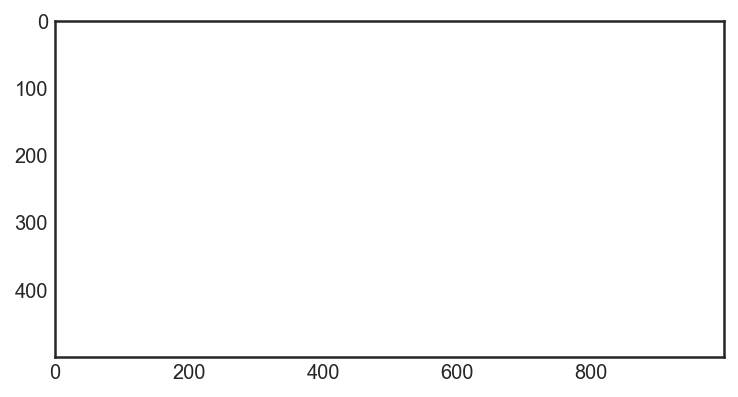

In [1148]:
plt.imshow(transit_depth_mask.T)

array([[[1.00462042e-08],
        [1.00926220e-08],
        [1.01392541e-08],
        ...,
        [9.90822810e-07],
        [9.95400829e-07],
        [1.00000000e-06]],

       [[1.03282336e-08],
        [1.03759544e-08],
        [1.04238956e-08],
        ...,
        [1.01863840e-06],
        [1.02334494e-06],
        [1.02807322e-06]],

       [[1.06181803e-08],
        [1.06672409e-08],
        [1.07165280e-08],
        ...,
        [1.04723486e-06],
        [1.05207353e-06],
        [1.05693455e-06]],

       ...,

       [[9.50503906e-03],
        [9.54895634e-03],
        [9.59307655e-03],
        ...,
        [9.37449539e-01],
        [9.41780951e-01],
        [9.46132376e-01]],

       [[9.77187615e-03],
        [9.81702633e-03],
        [9.86238513e-03],
        ...,
        [9.63766770e-01],
        [9.68219778e-01],
        [9.72693362e-01]],

       [[1.00462042e-02],
        [1.00926219e-02],
        [1.01392541e-02],
        ...,
        [9.90822810e-01],
        [9.9540

In [1117]:

sep.min()/(27*u.arcsec/u.pixel)

<Quantity 9.18289369e-05 pix2 / arcsec>

In [511]:
delta_mag + source_mag

array([22.        , 21.96993988, 21.93987976, 21.90981964, 21.87975952,
       21.8496994 , 21.81963928, 21.78957916, 21.75951904, 21.72945892,
       21.6993988 , 21.66933868, 21.63927856, 21.60921844, 21.57915832,
       21.5490982 , 21.51903808, 21.48897796, 21.45891784, 21.42885772,
       21.3987976 , 21.36873747, 21.33867735, 21.30861723, 21.27855711,
       21.24849699, 21.21843687, 21.18837675, 21.15831663, 21.12825651,
       21.09819639, 21.06813627, 21.03807615, 21.00801603, 20.97795591,
       20.94789579, 20.91783567, 20.88777555, 20.85771543, 20.82765531,
       20.79759519, 20.76753507, 20.73747495, 20.70741483, 20.67735471,
       20.64729459, 20.61723447, 20.58717435, 20.55711423, 20.52705411,
       20.49699399, 20.46693387, 20.43687375, 20.40681363, 20.37675351,
       20.34669339, 20.31663327, 20.28657315, 20.25651303, 20.22645291,
       20.19639279, 20.16633267, 20.13627255, 20.10621242, 20.0761523 ,
       20.04609218, 20.01603206, 19.98597194, 19.95591182, 19.92

In [513]:
10**-tess_cdpp(7)

1.965974958149475e-05

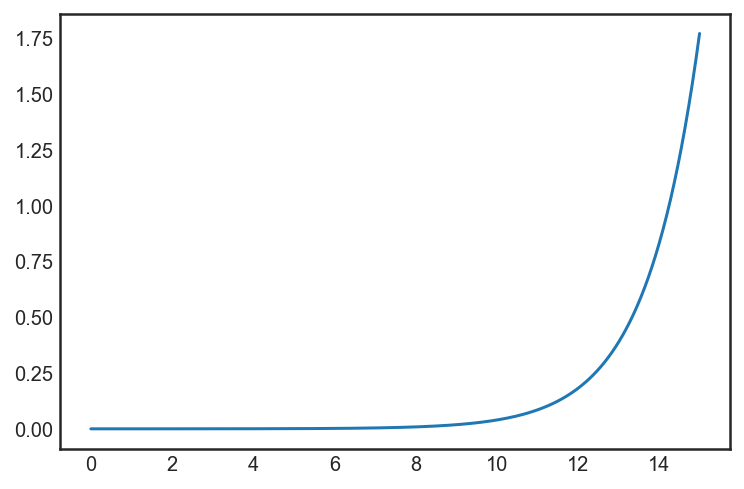

In [500]:
10**-tess_cdpp(18)

0.08445113769178658

In [476]:
[9, 100], [12.5, 1000], [15, 100000]

([9, 100], [12.5, 1000], [15, 100000])

In [475]:
source_mag + delta_mag

array([22.        , 21.96993988, 21.93987976, 21.90981964, 21.87975952,
       21.8496994 , 21.81963928, 21.78957916, 21.75951904, 21.72945892,
       21.6993988 , 21.66933868, 21.63927856, 21.60921844, 21.57915832,
       21.5490982 , 21.51903808, 21.48897796, 21.45891784, 21.42885772,
       21.3987976 , 21.36873747, 21.33867735, 21.30861723, 21.27855711,
       21.24849699, 21.21843687, 21.18837675, 21.15831663, 21.12825651,
       21.09819639, 21.06813627, 21.03807615, 21.00801603, 20.97795591,
       20.94789579, 20.91783567, 20.88777555, 20.85771543, 20.82765531,
       20.79759519, 20.76753507, 20.73747495, 20.70741483, 20.67735471,
       20.64729459, 20.61723447, 20.58717435, 20.55711423, 20.52705411,
       20.49699399, 20.46693387, 20.43687375, 20.40681363, 20.37675351,
       20.34669339, 20.31663327, 20.28657315, 20.25651303, 20.22645291,
       20.19639279, 20.16633267, 20.13627255, 20.10621242, 20.0761523 ,
       20.04609218, 20.01603206, 19.98597194, 19.95591182, 19.92

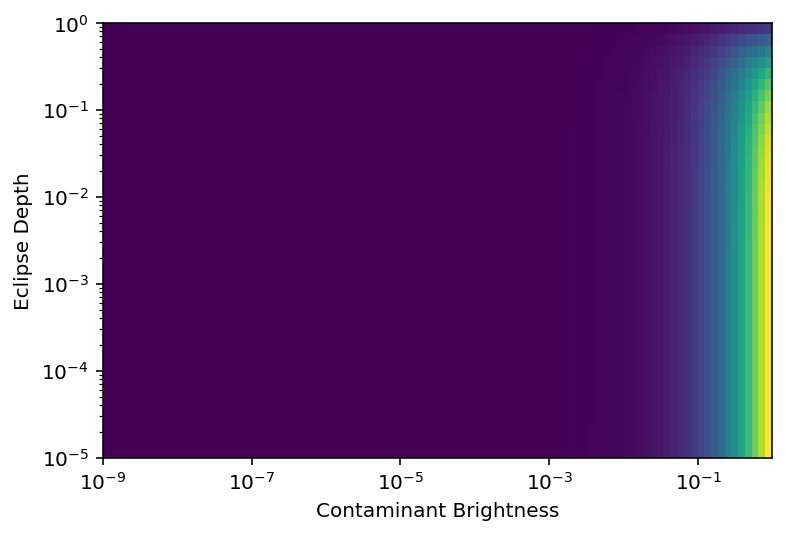

In [154]:
plt.pcolormesh(m2_ar, rat_ar, dcom[:, :, 100].value.T)
plt.xscale('log')
plt.xlabel('Contaminant Brightness')
plt.ylabel('Eclipse Depth')
plt.yscale('log')

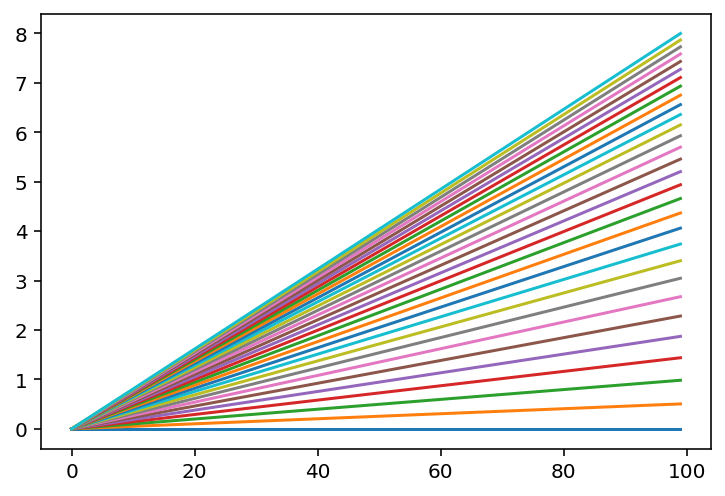

In [62]:
plt.plot(com2.T - com1.T)

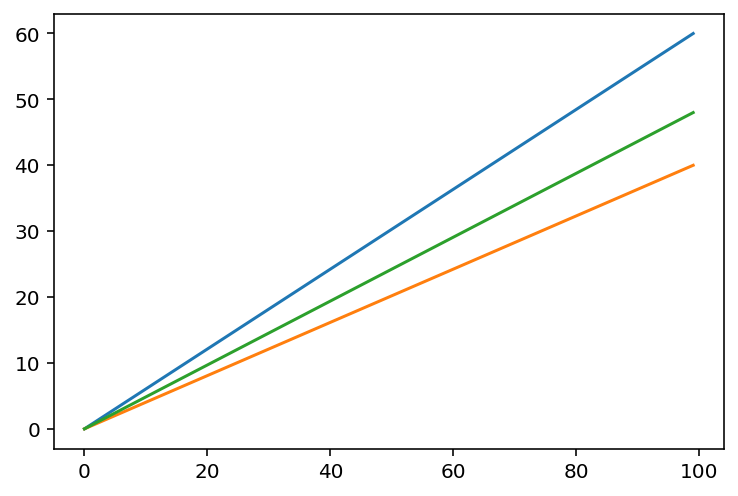

In [34]:
plt.plot(sep)
plt.plot(com1)
plt.plot(com2)
#plt.plot(com2 - com1)